In this notebook, we aim to perform the analysis leading to the plots in Figure3. 
This includes:
- Translation plots for each mouse region
- Scores (hit/near hit/miss) bar plot
- Pie charts on average scores per constituent part

In [1]:
# Import packages

import pandas as pd
import numpy as np
import os

import nibabel as nib
import nilearn
import nilearn.plotting
from nilearn import surface, datasets
import neuromaps
from neuromaps import nulls, transforms, resampling
from neuromaps import stats as nm_stats
from neuromaps.datasets import fetch_annotation

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import scipy.signal
from scipy.stats import gaussian_kde, kruskal
from scipy.signal import find_peaks
from scipy import optimize
from scipy.ndimage import binary_dilation

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp
import statannotations
from statannotations.Annotator import Annotator

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [9]:
# Define useful functions
  
def mirror_brain(half_map):
    human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
    affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine
    
    human_map = human_brain.copy()
    human_half_map = human_map[0:50,:,:]
    human_half_map[human_half_map>0] = half_map
    human_map[0:50,:,:]=human_half_map
    human_map[50:,:,:]=np.flip(human_half_map[1:49,:,:], axis=0)
    
    map_ = nib.Nifti1Image(human_map, affine)
    return map_

def translate_mouse_human(mouse_roi):
    mouse_vox_embedding = pd.read_csv('data/mouse_human/vae_emb/mouse_voxel_encoding_with_scaling.csv')
    mouse_regions = mouse_vox_embedding.iloc[:,-1]

    similarity=np.load('similarity_scored.csv.npy')

    temp = [similarity[mouse_regions==m_roi,:] for m_roi in mouse_roi]
    translated_half_map = []
    for i in range(len(temp)):
        translated_half_map += [*temp[i]]

    translated_half_map = np.sum(translated_half_map, axis=0)
    
    scaled = (translated_half_map - translated_half_map.min()) / (translated_half_map.max() - translated_half_map.min())
    unthresholded_translated = scaled.copy()
    
    unthresholded=mirror_brain(unthresholded_translated)

    # # Compute threshold as the last local minimum of the data distribution. NB, there may only be one peak (motor)
    # kde = gaussian_kde(unthresholded.get_fdata().flatten())
    # x_grid = np.linspace(0, 1, 200)
    # peaks=find_peaks(-kde.evaluate(x_grid)) # minimum as inverse of max returned by find peaks
    # if len(peaks[0]) == 0:
    #     threshold=np.median(unthresholded.get_fdata()[unthresholded.get_fdata()>0])
    # else:
    #     threshold=x_grid[peaks[0][-1]]
    threshold=0.6 # adjusted later in bar plot

    whole_map=unthresholded.get_fdata()
    whole_map[whole_map<threshold]=0
    whole_map = whole_map.reshape(unthresholded.get_fdata().shape)
    whole_map = nib.Nifti1Image(whole_map, unthresholded.affine)

    return whole_map, unthresholded, threshold


def plot_human_surf(mask_nii_h):
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")
    hemi= "left"
    radius = 8
    kind = 'ball'
    depth = 0.7
    inter='linear'
    n_samples=160
    pial_mesh = fsaverage[f"pial_{hemi}"]
    infl_mesh = fsaverage[f"infl_{hemi}"]
    X = surface.vol_to_surf(mask_nii_h, pial_mesh, radius=radius, interpolation=inter, n_samples=n_samples, kind=kind).T
    X = (X - X.min()) /(X.max() - X.min())
    nilearn.plotting.plot_surf_stat_map(infl_mesh,X,view=("lateral"), cmap='jet', colorbar=True)
    nilearn.plotting.plot_surf_stat_map(infl_mesh,X, view=("medial"), cmap='jet')

def plot_mouse_brain(map_m):
    # plot a mouse brain
    minc_mouse_low = nib.load('data/mouse_human/DSURQE_CCFv3_average_200um.mnc')
    affine_low = minc_mouse_low.affine
    minc_mouse_high = nib.load('data/mouse_human/DSURQE_CCFv3_average_50um.mnc')
    affine_high=minc_mouse_high.affine

    mask = minc_mouse_low.get_fdata().copy()
    analysis_mask = pd.read_csv('data/mouse_human/mouse_analysis_mask.csv')
    analysis_mask = analysis_mask['x']
    mask=mask.flatten()
    mask[analysis_mask]=map_m
    mask[analysis_mask==False]=0
    
    mask = mask.reshape(minc_mouse_low.get_fdata().shape)

    mask_nii = nib.Nifti1Image(mask, affine_low)
    mask_nii_high = nilearn.image.resample_to_img(mask_nii, minc_mouse_high)
    nilearn.plotting.plot_stat_map(mask_nii_high, bg_img=minc_mouse_high)


def thr_to_dice(thr, map_thresh, human_mask):
    N_total_roi = np.count_nonzero(human_mask.flatten())
    N_roi = np.count_nonzero((map_thresh.flatten()>thr)*human_mask.flatten())
    return -round((N_roi/N_total_roi),3) 

In [16]:
# Load data

human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine
human_labels = pd.read_csv('data/mouse_human/data.ign/atlas_ahba.csv')
long_label = human_labels['Long label']

In [11]:
# define human / mouse pairs to look at homology for
mouse_rois = [['Visual areas'], 
              ['Primary auditory area'], ['Primary motor area'], ['Primary somatosensory area'], 
              ['Main olfactory bulb', 'Anterior olfactory nucleus'], 
              ['Anterior cingulate area'],['Piriform area'], 
              ['Field CA1', 'Field CA2', 'Field CA3'], ['Subiculum', 'Dentate gyrus'], ['Claustrum'], ['Orbital area'], 
              ['Thalamus'], ['Hypothalamus'],['Caudoputamen'], ['Striatum ventral region'], ['Cortical subplate-other'],
             ['Pons'],['Medulla'], ['Inferior colliculus'], ['Superior colliculus, sensory related'], ['Pallidum'],
             ['Crus 1'], ['Crus 2'], ['Central lobule'], ['Paramedian lobule'],['Copula pyramidis'],['Culmen'],['Simple lobule'],['Paraflocculus'], 
              ['Flocculus'], ['Declive (VI)'],['Folium-tuber vermis (VII)'],['Pyramus (VIII)'],['Uvula (IX)'],['Nodulus (X)']]

In [12]:
human_rois = [['occipital pole','cuneus','lingual gyrus', 'fusiform gyrus, occipital part', 'inferior occipital gyrus ','superior occipital gyrus'], 
              ['transverse temporal gyrus TTG'], ['precentral gyrus'], ['postcentral gyrus'], 
              ['olfactory bulb', 'anterior olfactory nucleus'],
              ['cingulate gyrus, rostral part', 'cingulate gyrus, caudal part'], ['piriform cortex'],
             ['head of hippocampus','body of hippocampus ','tail of hippocampus'], ['anterior parahippocampal gyrus', 'posterior parahippocampal gyrus'],
             ['claustrum'], ['medial orbital gyrus', 'anterior intermediate orbital gyrus', 'posterior intermediate orbital gyrus', 'lateral intermediate orbital gyrus'],
              ['thalamus','anterior nuclear complex of thalamus','lateral dorsal nucleus of thalamus ','mediodorsal nucleus of thalamus','reuniens nucleus',
               'lateral posterior nucleus of thalamus','pulvinar of thalamus','ventral anterior nucleus of thalamus','ventral lateral nucleus of thalamus','ventral posterior lateral nucleus',
               'ventral posterior medial nucleus','dorsal lateral geniculate nucleus','medial geniculate nuclei','centromedian nucleus of thalamus',
               'parafascicular nucleus of thalamus','habenular nuclei','pineal body','zona incerta', 'midline nuclear complex'],
             ['hypothalamus','preoptic region of HTH','supraoptic region of HTH','tuberal region of HTH ', 'mammillary region of HTH'],
             ['head of caudate CaH','body of caudate CaB', 'tail of caudate CaT','putamen'],['nucleus accumbens'], ['amygdala AMY'], 
              ['pons'],['myelencephalon'],['inferior colliculus'],['superior colliculus'], ['external segment of globus pallidus', 'internal segment of globus pallidus'],
             ['crus I'], ['crus II'], ['cerebellar areas I-IV'], ['cerebellar area VIIb'],['cerebellar area VIIIb'], ['cerebellar area V'], ['cerebellar area VI'],['cerebellar area IX'],
             ['cerebellar area X'], ['vermal area VI'],['vermal VIIb'],['vermal VIIIa', 'vermal VIIIb'],['vermal IX'],['vermal X']]

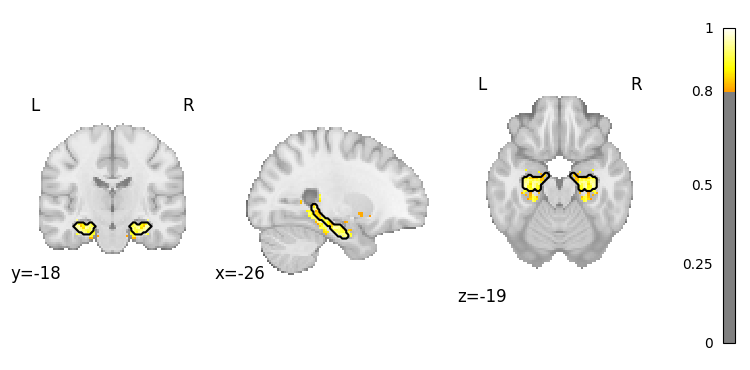

In [21]:
# plot some translations
# We can translated single regions or groups of regions that will be merged for translation.
# Later we will compute the optimal threshold for the translation but for now we will just 
# use for the hippocampus, th = 0.8
translated = translate_mouse_human(['Field CA1', 'Field CA2', 'Field CA3'])
display = nilearn.plotting.plot_stat_map(translated[1], draw_cross=False, threshold=0.8)

human_roi =['head of hippocampus','body of hippocampus ','tail of hippocampus']
human_mask = np.zeros(human_brain.shape[0:3]) 
inds=[]
for roi in human_roi:
    ind = np.where(long_label==roi)[0][0]
    inds.append(ind)
    
for i in inds: 
    human_mask[human_brain==i+1]=1
hipp = nib.Nifti1Image(human_mask, affine)
display.add_contours(hipp, colors='black', levels=[0.1])

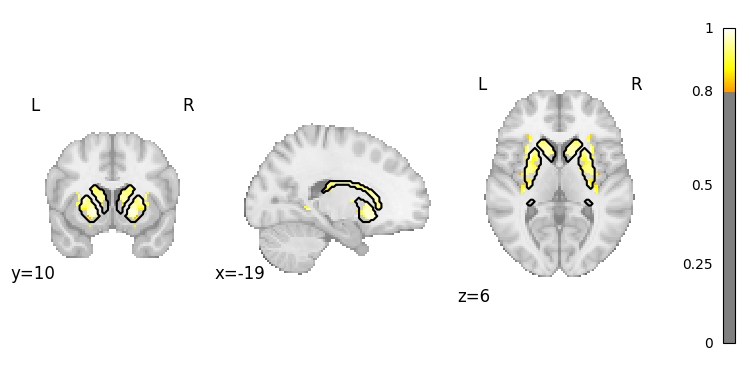

In [22]:
# Caudoputamen
translated = translate_mouse_human(['Caudoputamen'])
display = nilearn.plotting.plot_stat_map(translated[1], draw_cross=False, threshold=0.8)

human_roi =['head of caudate CaH','body of caudate CaB', 'tail of caudate CaT','putamen']
human_mask = np.zeros(human_brain.shape[0:3]) 
inds=[]
for roi in human_roi:
    ind = np.where(long_label==roi)[0][0]
    inds.append(ind)
    
for i in inds: 
    human_mask[human_brain==i+1]=1
cp = nib.Nifti1Image(human_mask, affine)
display.add_contours(cp, colors='black', levels=[0.1])

We want to know how 'good' the translations are. We could compute DICE scores (measure of overlap), but we noticed that in some cases this was not appropriate, for small regions for example. 
Instead, we look for each human target region the number of voxels of the translation from the mouse region that are above threshold. By dividing by the number of voxels in that region, we get an idea of how well we are hitting the target.
However, we can see how a translation that 'fills' the target completely could also be reaching many areas beyond the target, and therefore not be a very good translation. We could increase the size of the region, to see if with each iteration we are still getting a high proportion of voxels above threshold, or if the high similarity voxels remain inside the target area. 
To do that, we use the main constituent parts (cortex, subcortex, cerebellum, brainstem) that the target belongs to. The near hit score is defined as the number of high similarity voxels outside the target but inside the constituent part divided by the total number of voxels in (constituent - target). A miss is the number of voxels of high similarity in the rest of the brain divided by the number of voxels in the rest of the brain.
For example: 
- hippocampus has a hit score ~ 0.8, a near hit ~ 0, and miss ~ 0. Based on these scores, we have a very focal translation, and that is consistent with the plot that we looked at earlier.
- crus 1 has a hit score ~ 0.9, near hit ~ 0.9, and miss ~ 0. This is not a very focal translation, but remains inside the constituent part of the brain.

To compute these scores, we need masks of the different brain areas involved, and we need to define homologous pairs of regions in each constituent part. 

In [ ]:
# For all mouse-human pairs, compute 'hit', 'near hit', 'miss' scores and plot barplot.

mouse_cortex = [['Visual areas'], 
              ['Primary auditory area'], ['Primary motor area'], ['Primary somatosensory area'], 
              ['Main olfactory bulb', 'Anterior olfactory nucleus'], 
              ['Anterior cingulate area'],['Piriform area'], 
              ['Field CA1', 'Field CA2', 'Field CA3'], ['Subiculum', 'Dentate gyrus'], ['Claustrum'], ['Orbital area']]
human_cortex = [['occipital pole','cuneus','lingual gyrus', 'fusiform gyrus, occipital part', 'inferior occipital gyrus ','superior occipital gyrus'], 
              ['transverse temporal gyrus TTG'], ['precentral gyrus'], ['postcentral gyrus'], 
              ['olfactory bulb', 'anterior olfactory nucleus'],
              ['cingulate gyrus, rostral part', 'cingulate gyrus, caudal part'], ['piriform cortex'],
             ['head of hippocampus','body of hippocampus ','tail of hippocampus'], ['anterior parahippocampal gyrus', 'posterior parahippocampal gyrus'],
             ['claustrum'], ['medial orbital gyrus', 'anterior intermediate orbital gyrus', 'posterior intermediate orbital gyrus', 'lateral intermediate orbital gyrus']]

mouse_subcortex =[['Thalamus'], ['Hypothalamus'],['Caudoputamen'], ['Striatum ventral region'], ['Cortical subplate-other']]
human_subcortex =[['thalamus','anterior nuclear complex of thalamus','lateral dorsal nucleus of thalamus ','mediodorsal nucleus of thalamus','reuniens nucleus',
               'lateral posterior nucleus of thalamus','pulvinar of thalamus','ventral anterior nucleus of thalamus','ventral lateral nucleus of thalamus','ventral posterior lateral nucleus',
               'ventral posterior medial nucleus','dorsal lateral geniculate nucleus','medial geniculate nuclei','centromedian nucleus of thalamus',
               'parafascicular nucleus of thalamus','habenular nuclei','pineal body','zona incerta', 'midline nuclear complex'],
             ['hypothalamus','preoptic region of HTH','supraoptic region of HTH','tuberal region of HTH ', 'mammillary region of HTH'],
             ['head of caudate CaH','body of caudate CaB', 'tail of caudate CaT','putamen', 'posteroventral putamen'],['nucleus accumbens'], ['amygdala AMY'], ]

mouse_brainstem = [['Pons'],['Medulla'], ['Inferior colliculus'], ['Superior colliculus, sensory related'], ['Pallidum'],]
human_brainstem = [['pons'],['myelencephalon'],['inferior colliculus'],['superior colliculus'], ['external segment of globus pallidus', 'internal segment of globus pallidus']]

mouse_cerebellum = [['Crus 1'], ['Crus 2'], ['Central lobule'], ['Paramedian lobule'],['Copula pyramidis'],['Culmen'],['Simple lobule'],['Paraflocculus'], 
              ['Flocculus'], ['Declive (VI)'],['Folium-tuber vermis (VII)'],['Pyramus (VIII)'],['Uvula (IX)'],['Nodulus (X)']]
human_cerebellum = [['crus I'], ['crus II'], ['cerebellar areas I-IV'], ['cerebellar area VIIb'],['cerebellar area VIIIb'], ['cerebellar area V'], ['cerebellar area VI'],['cerebellar area IX'],
             ['cerebellar area X'], ['vermal area VI'],['vermal VIIb'],['vermal VIIIa', 'vermal VIIIb'],['vermal IX'],['vermal X']]

human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine
human_labels = pd.read_csv('data/mouse_human/data.ign/atlas_ahba.csv')
long_label = human_labels['Long label']

cortical_pairs = zip(mouse_cortex, human_cortex)
subcortical_pairs = zip(mouse_subcortex, human_subcortex)
brainstem_pairs = zip(mouse_brainstem, human_brainstem)
cerebellar_pairs = zip(mouse_cerebellum, human_cerebellum)

# Compute masks for each constituent part
# Cortex
cortical_brain_mask=np.zeros(human_brain.shape[0:3])
rois = [np.arange(1,6),np.arange(51,96),[106],np.arange(108,113)]
rois_list = []
for i in range(len(rois)):
    rois_list += [*rois[i]]   
for roi in range(len(rois_list)):
    cortical_brain_mask = cortical_brain_mask + 1*(human_brain==rois_list[roi])

# Subcortex
subcortical_brain_mask = np.zeros(human_brain.shape[0:3])
rois_sc = [np.arange(6,51), [104,105,107]]
rois_sc_list = []
for i in range(len(rois_sc)):
    rois_sc_list += [*rois_sc[i]]
    
for roi in range(len(rois_sc_list)):
    subcortical_brain_mask = subcortical_brain_mask + 1*(human_brain==rois_sc_list[roi])

# Brainstem
brainstem_mask = np.zeros(human_brain.shape[0:3])
rois_bs = [96,97,98,99,100,101,102,103]   
for roi in range(len(rois_bs)):
    brainstem_mask = brainstem_mask + 1*(human_brain==rois_bs[roi])

# Cerebellum
cerebellar_brain_mask=human_brain.copy()
cerebellar_brain_mask=1*(cerebellar_brain_mask>112)


# Initialise human mask to use in the loop 
human_mask = np.zeros(human_brain.shape[0:3]) 

# Initialise scores
N_hit=[]
N_near_hit=[]
N_miss=[]

for (ind,pairs) in enumerate(cortical_pairs):
    N_roi = []
    N_total_roi = []
    N_big_roi = []
    N_total_near = []
    N_out = []
    N_total_out = []
    
    human_roi=pairs[1]
    mouse_roi=pairs[0]
    translated = translate_mouse_human(mouse_roi, human_roi)
    map_ = translated[1].get_fdata()
    map_thresh = translated[0].get_fdata()
    threshold = translated[2]
    print(threshold)
    human_mask = np.zeros(human_brain.shape[0:3]) 
    inds=[]
    for roi in human_roi:
        ind = np.where(long_label==roi)[0][0]
        inds.append(ind)
        
    for i in inds: 
        human_mask[human_brain==i+1]=1
    
    # Get number of voxels in target that have value > new thresh
    # New threshold is set as the optimal value for dice (target / translated)
    # If there are no hit voxels in target, optimize on near hits
    if np.count_nonzero((map_thresh.flatten())*human_mask.flatten())>0:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, human_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        possible_thresholds = np.linspace(th, 1, 20)
        for t in possible_thresholds:
            N_total_roi = np.count_nonzero(human_mask.flatten())
            N_roi = np.count_nonzero((map_.flatten()>t)*human_mask.flatten())
            if N_roi/N_total_roi >= 0.9:
                th=t
        print(th)
        map_thresh = map_ > th
    else:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, cortical_brain_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        print(th)
        map_thresh = map_ > th
    
    N_total_roi = np.count_nonzero(human_mask.flatten())
    N_roi = np.count_nonzero(map_thresh.flatten()*human_mask.flatten())

    # Get number of voxels within broader subdivision
    N_big_roi = np.count_nonzero(map_thresh.flatten()*(cortical_brain_mask.flatten() - human_mask.flatten()))
    N_total_near = np.count_nonzero((cortical_brain_mask.flatten() - human_mask.flatten()))

    # Get number of voxels that fall outside the ROI
    N_out = np.count_nonzero(map_thresh.flatten()*(whole_brain_mask.flatten()-cortical_brain_mask.flatten())) 
    N_total_out = np.count_nonzero((whole_brain_mask.flatten()-cortical_brain_mask.flatten())) 
    
    N_hit.append(N_roi / N_total_roi)
    N_near_hit.append(N_big_roi / N_total_near)
    N_miss.append(N_out / N_total_out)
    
    print('%s : hit=%f0.2 | near_hit=%f0.2 | miss=%f0.2' % (human_roi, N_roi/N_total_roi, N_big_roi/N_total_near, N_out/N_total_out)) 

for (ind,pairs) in enumerate(subcortical_pairs):
    N_roi = []
    N_total_roi = []
    N_big_roi = []
    N_total_near = []
    N_out = []
    N_total_out = []
    
    human_roi=pairs[1]
    mouse_roi=pairs[0]
    
    translated = translate_mouse_human(mouse_roi, human_roi)
    map_ = translated[1].get_fdata()
    map_thresh = translated[0].get_fdata()
    threshold = translated[2]
    print(threshold)

    human_mask = np.zeros(human_brain.shape[0:3])
    inds=[]
    for roi in human_roi:
        ind = np.where(long_label==roi)[0][0]
        inds.append(ind)
        
    for i in inds: 
        human_mask[human_brain==i+1]=1
        
    # Get number of voxels in target that have value > new_thresh
    # New threshold is set as the optimal value (target / translated)
    if np.count_nonzero((map_thresh.flatten())*human_mask.flatten())>0:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, human_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        possible_thresholds = np.linspace(th, 1, 20)
        for t in possible_thresholds:
            N_total_roi = np.count_nonzero(human_mask.flatten())
            N_roi = np.count_nonzero((map_.flatten()>t)*human_mask.flatten())
            if N_roi/N_total_roi >= 0.9:
                th=t
        print(th)
        map_thresh = map_ > th
    else:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, subcortical_brain_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        print(th)
        map_thresh = map_ > th
    
    N_total_roi = np.count_nonzero(human_mask.flatten())
    N_roi = np.count_nonzero(map_thresh.flatten()*human_mask.flatten())

    # Get number of voxels within broader subdivision
    N_big_roi = np.count_nonzero(map_thresh.flatten()*(subcortical_brain_mask.flatten() - human_mask.flatten()))
    N_total_near = np.count_nonzero((subcortical_brain_mask.flatten() - human_mask.flatten()))

    # Get number of voxels that fall outside the ROI
    N_out = np.count_nonzero(map_thresh.flatten()*(whole_brain_mask.flatten()-subcortical_brain_mask.flatten())) 
    N_total_out = np.count_nonzero((whole_brain_mask.flatten()-subcortical_brain_mask.flatten())) 
    
    N_hit.append(N_roi / N_total_roi)
    N_near_hit.append(N_big_roi / N_total_near)
    N_miss.append(N_out / N_total_out)
    
    print('%s : hit=%f | near_hit=%f | miss=%f' % (human_roi, N_roi/N_total_roi, N_big_roi/N_total_near, N_out/N_total_out)) 

for (ind,pairs) in enumerate(brainstem_pairs):
    N_roi = []
    N_total_roi = []
    N_big_roi = []
    N_total_near = []
    N_out = []
    N_total_out = []
    
    human_roi=pairs[1]
    mouse_roi=pairs[0]
    
    translated = translate_mouse_human(mouse_roi, human_roi)
    map_ = translated[1].get_fdata()
    map_thresh = translated[0].get_fdata()
    threshold = translated[2]
    print(threshold)
    
    human_mask = np.zeros(human_brain.shape[0:3])
    inds=[]
    for roi in human_roi:
        ind = np.where(long_label==roi)[0][0]
        inds.append(ind)
        
    for i in inds: 
        human_mask[human_brain==i+1]=1
    
    # Get number of voxels in target that have value > new_thresh
    # New threshold is set as the optimal value for dice (target / translated)
    if np.count_nonzero((map_thresh.flatten())*human_mask.flatten())>0:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, human_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        possible_thresholds = np.linspace(th, 1, 20)
        for t in possible_thresholds:
            N_total_roi = np.count_nonzero(human_mask.flatten())
            N_roi = np.count_nonzero((map_.flatten()>t)*human_mask.flatten())
            if N_roi/N_total_roi >= 0.9:
                th=t
        print(th)
        map_thresh = map_ > th
    else:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, brainstem_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        print(th)
        map_thresh = map_ > th
    
    N_total_roi = np.count_nonzero(human_mask.flatten())
    N_roi = np.count_nonzero(map_thresh.flatten()*human_mask.flatten())

    # Get number of voxels within broader subdivision but outside target
    N_big_roi = np.count_nonzero(map_thresh.flatten()*(brainstem_mask.flatten() - human_mask.flatten()))
    N_total_near = np.count_nonzero((brainstem_mask.flatten() - human_mask.flatten()))

    # Get number of voxels that fall outside the constituent part
    N_out = np.count_nonzero(map_thresh.flatten()*(whole_brain_mask.flatten()-brainstem_mask.flatten())) 
    N_total_out = np.count_nonzero((whole_brain_mask.flatten()-brainstem_mask.flatten())) 
    
    N_hit.append(N_roi / N_total_roi)
    N_near_hit.append(N_big_roi / N_total_near)
    N_miss.append(N_out / N_total_out)
    
    print('%s : hit=%f | near_hit=%f | miss=%f' % (human_roi, N_roi/N_total_roi, N_big_roi/N_total_near, N_out/N_total_out)) 

for (ind,pairs) in enumerate(cerebellar_pairs):
    N_roi = []
    N_total_roi = []
    N_big_roi = []
    N_total_near = []
    N_out = []
    N_total_out = []
    
    human_roi=pairs[1]
    mouse_roi=pairs[0]
    translated = translate_mouse_human(mouse_roi, human_roi)
    map_ = translated[1].get_fdata()
    map_thresh = translated[0].get_fdata()
    threshold = translated[2]
    print(threshold)
    
    human_mask = np.zeros(human_brain.shape[0:3])
    inds=[]
    for roi in human_roi:
        ind = np.where(long_label==roi)[0][0]
        inds.append(ind)
        
    for i in inds: 
        human_mask[human_brain==i+1]=1
    
    # Get number of voxels in target that have value > new_thresh
    # New threshold is set as the optimal value for dice (target / translated)
    if np.count_nonzero((map_thresh.flatten())*human_mask.flatten())>0:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, human_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        possible_thresholds = np.linspace(th, 1, 20)
        for t in possible_thresholds:
            N_total_roi = np.count_nonzero(human_mask.flatten())
            N_roi = np.count_nonzero((map_.flatten()>t)*human_mask.flatten())
            if N_roi/N_total_roi >= 0.9:
                th=t
        print(th)
        map_thresh = map_ > th
    else:
        opt_thresh = scipy.optimize.minimize_scalar(thr_to_dice, args=(map_, cerebellar_brain_mask), method='bounded', bounds=(0.6,0.9))
        th = opt_thresh.x
        print(th)
        map_thresh = map_ > th
    
    N_total_roi = np.count_nonzero(human_mask.flatten())
    N_roi = np.count_nonzero(map_thresh.flatten()*human_mask.flatten())

    # Get number of voxels within broader subdivision
    N_total_near = np.count_nonzero((cerebellar_brain_mask.flatten() - human_mask.flatten()))
    N_big_roi = np.count_nonzero(map_thresh.flatten()*(cerebellar_brain_mask.flatten() - human_mask.flatten()))

    # Get number of voxels that fall outside the broader subdivision
    N_total_out = np.count_nonzero((whole_brain_mask.flatten()-cerebellar_brain_mask.flatten())) 
    N_out = np.count_nonzero(map_thresh.flatten()*(whole_brain_mask.flatten()-cerebellar_brain_mask.flatten())) 

    N_hit.append(N_roi / N_total_roi)
    N_near_hit.append(N_big_roi / N_total_near)
    N_miss.append(N_out / N_total_out)
    
    print('%s : hit=%f | near_hit=%f | miss=%f' % (human_roi, N_roi/N_total_roi, N_big_roi/N_total_near, N_out/N_total_out)) 

In [ ]:
mouse_list = []
for i in range(len(mouse_rois)):
    if len(mouse_rois[i])==1:
        mouse_list += [*mouse_rois[i]]
    else:
        if mouse_rois[i][0]=='Field CA1':
            mouse_list.append('Hippocampus')
        else:
            mouse_list.append(mouse_rois[i][0])

        
d = {'Regions': mouse_list, '% Hit': N_hit, '% Near Hit': N_near_hit, '% Miss': N_miss}
scores = pd.DataFrame(d)
ax = scores.plot.barh(x='Regions', stacked=False, figsize=(5,12), legend=False)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.15))


cortex_list = mouse_list[0:11]
subcortex_list = mouse_list[11:16]
brainstem_list = mouse_list[16:21]
cerebellum_list = mouse_list[21:]

labels=ax.get_yticklabels()

ticks=ax.get_yticks()

for label, tick in zip(labels, ticks):
    for item in cortex_list:
        if label.get_text()==item:
            label.set_color('indianred')
            label.set_fontsize(12)
    for item in subcortex_list:
        if label.get_text()==item:
            label.set_color('limegreen')
            label.set_fontsize(12)
    for item in brainstem_list:
        if label.get_text()==item:
            label.set_color('goldenrod')
            label.set_fontsize(12)
    for item in cerebellum_list:
        if label.get_text()==item:
            label.set_color('steelblue')
            label.set_fontsize(12)

plt.show()

In [ ]:
# Make pie plot of average hit / near hit / miss per zone
cortex_list = mouse_list[0:11]
subcortex_list = mouse_list[11:16]
brainstem_list = mouse_list[16:21]
cerebellum_list = mouse_list[21:]

average_hit_cortex = scores['% Hit'][0:11].mean()
average_nearhit_cortex = scores['% Near Hit'][0:11].mean()
average_miss_cortex = np.mean(scores['% Miss'][0:11])

average_hit_subcortex = scores['% Hit'][11:16].mean()
average_nearhit_subcortex = scores['% Near Hit'][11:16].mean()
average_miss_subcortex = np.mean(scores['% Miss'][11:16])

average_hit_brainstem = scores['% Hit'][16:21].mean()
average_nearhit_brainstem = scores['% Near Hit'][16:21].mean()
average_miss_brainstem = np.mean(scores['% Miss'][16:21])

average_hit_cerebellum = scores['% Hit'][21:].mean()
average_nearhit_cerebellum = scores['% Near Hit'][21:].mean()
average_miss_cerebellum = np.mean(scores['% Miss'][21:])

plt.pie([average_hit_cortex,average_nearhit_cortex,average_miss_cortex], labels=['Hit', 'Near Hit','Miss'])

In [ ]:
plt.pie([average_hit_subcortex,average_nearhit_subcortex,average_miss_subcortex],labels=['Hit', 'Near Hit','Miss'])

In [ ]:
plt.pie([average_hit_cerebellum,average_nearhit_cerebellum,average_miss_cerebellum], labels=['Hit', 'Near Hit','Miss'])

We also want to know if there is a significant interaction between score type and constituent part.
For this we perform an ANOVA as follows:

In [ ]:
cortex_list = mouse_list[0:11]
subcortex_list = mouse_list[11:16]
brainstem_list = mouse_list[16:21]
cerebellum_list = mouse_list[21:]
Structure = []
for i in range(len(cortex_list)):
    Structure.append('cortex')
for i in range(len(subcortex_list)):
    Structure.append('subcortex')
for i in range(len(brainstem_list)):
    Structure.append('brainstem')
for i in range(len(cerebellum_list)):
    Structure.append('cerebellum')


scores['Structure']=Structure

In [ ]:
# Check non parametric stats
kruskal(scores['% Hit'], scores['% Near Hit'], scores['% Miss'])

In [ ]:
# Anova
scores_test = scores.copy()
dat = pd.melt(scores_test, id_vars=['Structure'], value_vars=['% Hit', '% Near Hit', '% Miss'])
model = ols('value ~ C(Structure) + C(variable) + C(Structure):C(variable)', data=dat).fit()
sm.stats.anova_lm(model, typ=2)

In [ ]:
sp.posthoc_ttest(dat, val_col='value', group_col='Structure', p_adjust='fdr_bh')

In [ ]:
dat_nearhit = dat.loc[dat['variable']=='% Near Hit']
dat_hit = dat.loc[dat['variable']=='% Hit']
dat_miss = dat.loc[dat['variable']=='% Miss']

In [ ]:
con=sp.posthoc_conover(dat_miss, val_col='value', group_col='Structure',p_adjust='fdr_tsbky')
remove = np.tril(np.ones(con.shape),k=0).astype('bool')
con[remove]=np.nan
molten=pd.melt(con, ignore_index=False).reset_index().dropna()

del data

structure = np.unique(Structure)
data = dat_hit

con=sp.posthoc_conover(data, val_col='value', group_col='Structure',p_adjust='fdr_tsbky')
remove = np.tril(np.ones(con.shape),k=0).astype('bool')
con[remove]=np.nan
molten=pd.melt(con, ignore_index=False).reset_index().dropna()

# ax = sns.boxplot(data=data, x="Structure", y="value")
fig, ax = plt.subplots()
sns.boxplot(ax=ax, data=data, x="Structure", y="value")
fig.set_size_inches(4, 4)
sns.swarmplot(data=data, x="Structure", y="value", color='lightblue', dodge=True)
pairs=[(i[1]['index'], i[1]["variable"]) for i in molten.iterrows()]
p_values = [i[1]["value"] for i in molten.iterrows()]

annotator = Annotator(ax, pairs, data=data, x='Structure', y='value')
annotator.configure(text_format="star", loc='inside')
annotator.set_pvalues_and_annotate(p_values)

In [ ]:
del data

structure = np.unique(Structure)
data = dat_miss

con=sp.posthoc_conover(data, val_col='value', group_col='Structure',p_adjust='fdr_tsbky')
remove = np.tril(np.ones(con.shape),k=0).astype('bool')
con[remove]=np.nan
molten=pd.melt(con, ignore_index=False).reset_index().dropna()

# ax = sns.boxplot(data=data, x="Structure", y="value")
fig, ax = plt.subplots()
sns.boxplot(ax=ax, data=data, x="Structure", y="value")
fig.set_size_inches(4, 4)
sns.swarmplot(data=data, x="Structure", y="value", color='lightblue', dodge=True)
pairs=[(i[1]['index'], i[1]["variable"]) for i in molten.iterrows()]
p_values = [i[1]["value"] for i in molten.iterrows()]

annotator = Annotator(ax, pairs, data=data, x='Structure', y='value')
annotator.configure(text_format="star", loc='inside')
annotator.set_pvalues_and_annotate(p_values)

In [ ]:
del data

structure = np.unique(Structure)
data = dat_nearhit

con=sp.posthoc_conover(data, val_col='value', group_col='Structure',p_adjust='fdr_tsbky')
remove = np.tril(np.ones(con.shape),k=0).astype('bool')
con[remove]=np.nan
molten=pd.melt(con, ignore_index=False).reset_index().dropna()

# ax = sns.boxplot(data=data, x="Structure", y="value")
fig, ax = plt.subplots()
sns.boxplot(ax=ax, data=data, x="Structure", y="value")
fig.set_size_inches(4, 4)
sns.swarmplot(data=data, x="Structure", y="value", color='lightblue', dodge=True)
pairs=[(i[1]['index'], i[1]["variable"]) for i in molten.iterrows()]
p_values = [i[1]["value"] for i in molten.iterrows()]

annotator = Annotator(ax, pairs, data=data, x='Structure', y='value')
annotator.configure(text_format="star", loc='inside')
annotator.set_pvalues_and_annotate(p_values)